In [364]:
# Import libraries. To install any that you don't already have downloaded, run "pip3 install libraryname" in terminal.

# from __future__ import absolute_import, division, print_function

import pathlib
import pandas as pd
import numpy as np

import tensorflow as tf
# from tensorflow import keras
import csv
# from tensorflow.keras import layers
from sklearn.model_selection import GridSearchCV
from verstack import LGBMTuner
import matplotlib.pyplot as pl
import shap

import xgboost as xg

import time

import math
import statistics
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats

# from sklearn.cluster import DBSCAN

import lightgbm as lgb

from sklearn.neighbors import KNeighborsRegressor
print("completed package import")

completed package import


In [385]:
# Assign outcome variable
outcome = "kg.CO2.per.nm"

# Read in data
data = pd.read_csv("../data/nn-data-21.csv")
testdata = pd.read_csv("../data/test-data.csv")

dataset = data.copy()
testdataset = testdata.copy()


In [386]:
# Remove unwanted variables from training data

shiptypeEU = pd.get_dummies(dataset["ShiptypeEU"])
dataset.pop("ShiptypeEU")
dataset = dataset.join(shiptypeEU)

shiptypelevel2 =pd.get_dummies(dataset["ShiptypeLevel2"])
dataset.pop("ShiptypeLevel2")
dataset = dataset.join(shiptypelevel2)

# operator =pd.get_dummies(dataset["Operator"])
dataset.pop("Operator")
# dataset = dataset.join(operator)

# FlagNameBin =pd.get_dummies(dataset["FlagNameBin"])
dataset.pop("FlagNameBin")
# dataset = dataset.join(FlagNameBin)

# FlagNameContinent =pd.get_dummies(dataset["FlagNameContinent"])
dataset.pop("FlagNameContinent")
# dataset = dataset.join(FlagNameContinent)


# Remove columns with boolean values
dataset.pop("Deadweight_imputed")
dataset.pop("GrossTonnage_imputed")
dataset.pop("Length_imputed")
dataset.pop("Breadth_imputed")
dataset.pop("Draught_imputed")
dataset.pop("Powerkwmax_imputed")
dataset.pop("Powerkwaux_imputed")
dataset.pop("Speed_imputed")
dataset.pop("TEU_imputed")

#remove 
dataset.pop("shiptype.original")
trainTEU = dataset.pop("TEU")
dataset.pop("NumImputedFields")

#remove EU params
dataset.pop("distance.traveled")
dataset.pop("average.speed")
dataset.pop("time.at.sea")

0        3004.65
1        3508.83
2         742.53
3        2080.46
4        3303.66
          ...   
29911    1424.34
29912    1527.66
29913     329.67
29914     461.74
29915     617.25
Name: time.at.sea, Length: 29916, dtype: float64

In [387]:
# Remove the same variables from the test dataset.

shiptypeEU = pd.get_dummies(testdataset["ShiptypeEU"])
testdataset.pop("ShiptypeEU")
testdataset = testdataset.join(shiptypeEU)

shiptypelevel2 =pd.get_dummies(testdataset["ShiptypeLevel2"])
testdataset.pop("ShiptypeLevel2")
testdataset = testdataset.join(shiptypelevel2)

# operator =pd.get_dummies(dataset["Operator"])
testdataset.pop("Operator")
# dataset = dataset.join(operator)

FlagNameBin =pd.get_dummies(testdataset["FlagNameBin"])
testdataset.pop("FlagNameBin")
# testdataset = testdataset.join(FlagNameBin)

# FlagNameContinent =pd.get_dummies(dataset["FlagNameContinent"])
testdataset.pop("FlagNameContinent")
# dataset = dataset.join(FlagNameContinent)


#remove columns with boolean values
testdataset.pop("Deadweight_imputed")
testdataset.pop("GrossTonnage_imputed")
testdataset.pop("Length_imputed")
testdataset.pop("Breadth_imputed")
testdataset.pop("Draught_imputed")
testdataset.pop("Powerkwmax_imputed")
testdataset.pop("Powerkwaux_imputed")
testdataset.pop("Speed_imputed")
testdataset.pop("TEU_imputed")

#remove 
testdataset.pop("shiptype.original")
testTEU = testdataset.pop("TEU")
testdataset.pop("NumImputedFields")

testdataset.pop("distance.traveled")
testdataset.pop("average.speed")
testdataset.pop("time.at.sea")

0         298.85
1         608.33
2        2331.00
3        2496.03
4        2311.70
          ...   
15021    1762.40
15022    2638.92
15023     594.63
15024    1119.42
15025    2741.36
Name: time.at.sea, Length: 15026, dtype: float64

In [159]:
# For performing five-fold cross validation. Skip to train data on the full train dataset.

# Make train and test sets
np.random.seed(1234)
ids = dataset.IMO.unique()
np.random.shuffle(ids)
test = []
for i in range(5):
    test.append(ids[int(i*0.2*len(ids)):int(i*0.2*len(ids)+0.2*len(ids))])

# # np.concatenate([trainsplit,trainsplit2])
trainsplit = np.concatenate([test[0],test[1],test[2],test[3]])
# trainsplit = ids[0:int(0.2*len(ids))]
# trainsplit2 = ids[int(0.2*len(ids)):len(ids)]
# testsplit = ids[int(0.0*len(ids)):int(0.2*len(ids))]
testsplit = test[4]

train_dataset = dataset[dataset["IMO"].isin(trainsplit)]
test_dataset = dataset[dataset["IMO"].isin(testsplit)]

In [388]:
# Assign new names to train and test datasets. Skip this step if doing five-fold cross validation.

train_dataset = dataset
test_dataset = testdataset

In [389]:
# Remove the outcome variable and IMO numbers to avoid memory leak. Print training and test datasets to make sure their columns match.

train_labels = train_dataset.pop(outcome)
test_labels = test_dataset.pop(outcome)

# Remove IMO Number as a predictor after using it to seperate data
train_dataset.pop("IMO")
test_dataset.pop("IMO")


0        9109768
1        8907280
2        9135896
3        9557848
4        9188881
          ...   
15021    9883481
15022    9897705
15023    9902196
15024    9903827
15025    9903839
Name: IMO, Length: 15026, dtype: int64

In [371]:
# Following is for training Tensorflow Sequential (fully connected neural net).

# Normalize data
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
def norm(x):
    # return (x-train_stats['min'])/ (train_stats['max'] - train_stats['min'])
    return (x-train_stats['mean'])/ train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [373]:
# Define and build model
def build_model():
    model = keras.Sequential([
        layers.Dense(128, activation = tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        layers.Dense(128, activation=tf.nn.relu),
        layers.Dense(1)
    ])

    optimizer = 'adam'
    model.compile(loss='mse', optimizer=optimizer, metrics = ['mae','mse'])
    return model

model = build_model()
model.summary()

# Incorporate early stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 128)               4096      
                                                                 
 dense_26 (Dense)            (None, 128)               16512     
                                                                 
 dense_27 (Dense)            (None, 1)                 129       
                                                                 
Total params: 20,737
Trainable params: 20,737
Non-trainable params: 0
_________________________________________________________________


In [374]:
# Print dots to show training progress
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print(epoch)


EPOCHS = 500

In [375]:
history = model.fit(
    normed_train_data, train_labels,
    epochs = EPOCHS, validation_split = 0.2, verbose = 0,
    callbacks=[early_stop, PrintDot()]
)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print(hist.tail())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
           loss        mae          mse     val_loss    val_mae      val_mse  \
29  5603.823730  44.771999  5603.823730  5383.771484  43.577358  5383.771484   
30  5566.769531  44.612839  5566.769531  5619.815430  45.135109  5619.815430   
31  5554.511230  44.477856  5554.511230  5410.109863  44.717888  5410.109863   
32  5541.052246  44.547146  5541.052246  5291.717773  43.173004  5291.717773   
33  5515.061523  44.574482  5515.061523  5973.134277  47.862968  5973.134277   

    epoch  
29     29  
30     30  
31     31  
32     32  
33     33  


In [376]:
# Plot error history
import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Absolute Error")
    plt.plot(hist["epoch"], hist["mae"], label = "Train Error")
    plt.plot(hist["epoch"],hist["val_mae"], label = "Validation Error")
    plt.legend()
    plt.ylim([0,120])

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error")
    plt.plot(hist["epoch"], hist["mse"], label = "Train Error")
    plt.plot(hist["epoch"],hist["val_mse"], label = "Validation Error")
    plt.legend()
    plt.ylim([0,8000])
    plt.show()

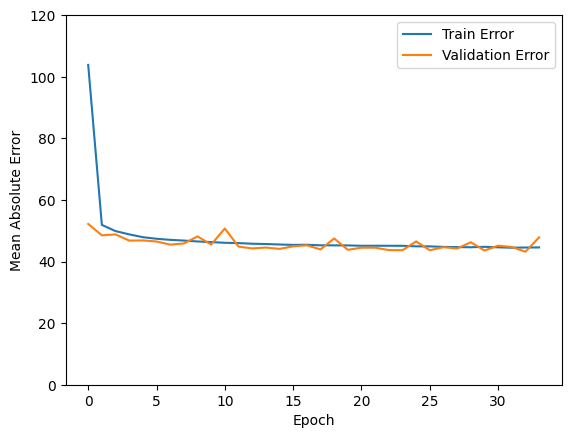

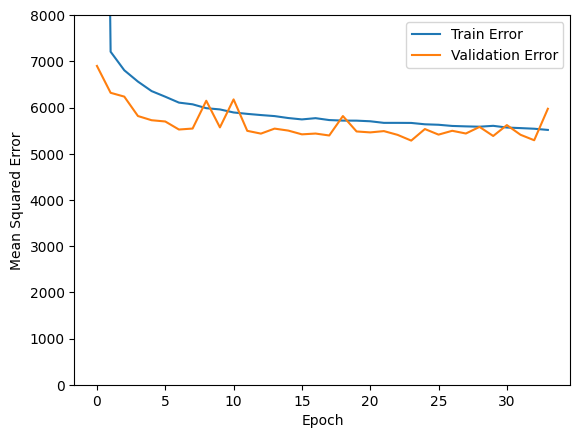

Testing set Mean Absolute Error: 49.95 kg CO2
Testing set Mean Squared Error: 8251.40 kg CO2
470/470 [==============================] - 1s 3ms/step


In [378]:
plot_history(history)


loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose = 0)
print("Testing set Mean Absolute Error: {:5.2f} kg CO2".format(mae))
print("Testing set Mean Squared Error: {:5.2f} kg CO2".format(mse))

# Make predictions on test data
test_predictions = model.predict(normed_test_data).flatten()

In [379]:
# Make predictions with XGBoost

print("Running XGBoost")

# For tuning hyperparameters
# err = 10000000
# best = 1
# for n in range(300,450):
#     for d in range(5,8):
#         model = xg.XGBRegressor(objective ='reg:squarederror', n_estimators = n,max_depth=d,tree_method='gpu_hist', seed = 123)
#         model.fit(train_dataset, train_labels)
#         test_predictions = model.predict(test_dataset)
#         mse = mean_squared_error(test_labels, test_predictions)
#         rmse = math.sqrt(mse)
#         nrmse = rmse/(statistics.stdev(test_labels))
#         if nrmse < err:
#             print("n: " + str(n) +" d: " + str(d) +  " err: "+ str(nrmse))
#             err = nrmse
#             best = n
# print("best n: " + str(best))

# Train based on best hyperparameters found
model = xg.XGBRegressor(learning_rate = 0.015, n_estimators = 2000, max_depth = 6)
model.fit(train_dataset, train_labels)
test_predictions = model.predict(test_dataset)

Running XGBoost


In [380]:
# Make predictions with KNN

print("Running KNN")

def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

# For tuning KNN
# best = 1
# a_mae = 100000000000
# a_nrmse = 100000000000
# for n in range(2,30):
#     knn = KNeighborsRegressor(n_neighbors=n)
#     knn.fit(train_dataset,train_labels)
#     test_predictions = knn.predict(test_dataset)
#     mse = mean_squared_error(test_labels, test_predictions)
#     rmse = math.sqrt(mse)
#     nrmse = rmse/(statistics.stdev(test_labels))
#     MAPE = mape(test_labels, test_predictions)
#     if  MAPE < a_mae:
#         a_nrmse = nrmse
#         a_mae = MAPE
#         best = n
#         print(best)
# print("n: " + str(best))

knn = KNeighborsRegressor(n_neighbors=2)        # 11 is optimal in terms of nrmse
knn.fit(train_dataset,train_labels)
test_predictions = knn.predict(test_dataset)
# testdatasetout["knn.predicted"] = test_predictions.tolist()

Running KNN


Running LGBM
[1]	valid_0's l1: 155.715
Training until validation scores don't improve for 30 rounds
[2]	valid_0's l1: 151.49
[3]	valid_0's l1: 147.531
[4]	valid_0's l1: 143.568
[5]	valid_0's l1: 139.745
[6]	valid_0's l1: 136.01
[7]	valid_0's l1: 132.399
[8]	valid_0's l1: 128.948
[9]	valid_0's l1: 125.584
[10]	valid_0's l1: 122.38
[11]	valid_0's l1: 119.262
[12]	valid_0's l1: 117.405
[13]	valid_0's l1: 114.415
[14]	valid_0's l1: 111.534
[15]	valid_0's l1: 108.793
[16]	valid_0's l1: 106.121
[17]	valid_0's l1: 103.537
[18]	valid_0's l1: 101.107
[19]	valid_0's l1: 98.7006
[20]	valid_0's l1: 96.3934
[21]	valid_0's l1: 94.1716
[22]	valid_0's l1: 92.0524
[23]	valid_0's l1: 90.0189
[24]	valid_0's l1: 88.0247
[25]	valid_0's l1: 86.0974
[26]	valid_0's l1: 84.2449
[27]	valid_0's l1: 82.4971
[28]	valid_0's l1: 80.7684
[29]	valid_0's l1: 79.1073
[30]	valid_0's l1: 77.518
[31]	valid_0's l1: 76.0118
[32]	valid_0's l1: 74.5749
[33]	valid_0's l1: 73.2137
[34]	valid_0's l1: 71.855
[35]	valid_0's l1: 70.

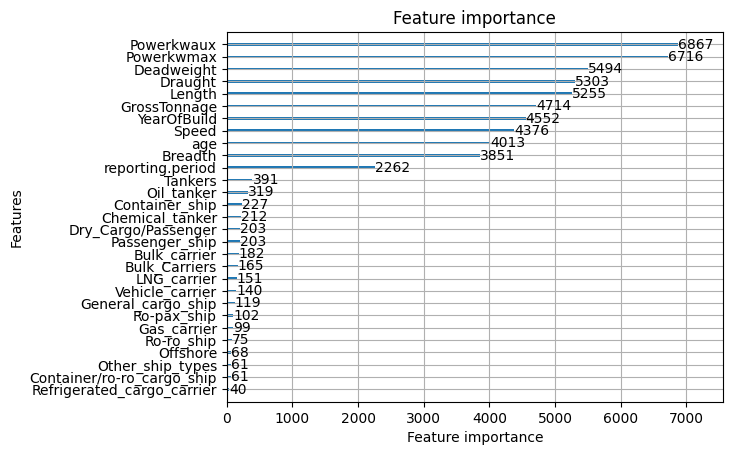

In [390]:
# Make predictions with LGBM

print("Running LGBM")

params = {      # BEST PARAMS
'learning_rate'                    : 0.03,
'num_leaves'                       : 210,
'colsample_bytree'                 : 0.5075219704535351,
'subsample'                        : 0.5599262550238809,
'verbosity'                        : -1,
'random_state'                     : 42,
'device_type'                      : 'cpu',
'objective'                        : 'regression',
'metric'                           : 'l1',
'num_threads'                      : 2,
'reg_alpha'                        : 8.581024000021709e-08,
'min_sum_hessian_in_leaf'          : 0.2918528036972111,
'reg_lambda'                       : 2.4641613805417514e-06,
'n_estimators'                     : 343,
}

# Loading data
lgb_train = lgb.Dataset(train_dataset, train_labels)
lgb_eval = lgb.Dataset(test_dataset, test_labels, reference=lgb_train)
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=30)
lgb.plot_importance(model)
plt.show()


# For tuning hyperparamters
# tuner = LGBMTuner(metric='mae',trials=1000)
# tuner.fit(train_dataset, train_labels)
# tuner.plot_importances()
# tuner.plot_intermediate_values()
# tuner.plot_param_importances()
# tuner.plot_optimization_history()

test_predictions = model.predict(test_dataset)

In [381]:
# The following is for training LGBM with TEU on Container ships

train_dataset.loc[:,"TEU"] = trainTEU
test_dataset.loc[:,"TEU"] = testTEU
train_dataset.loc[:,"label"] = train_labels
test_dataset.loc[:,"label"] = test_labels
train_dataset = train_dataset[train_dataset["Container ship"] == 1]
test_dataset = test_dataset[test_dataset["Container ship"] == 1]
train_labels = train_dataset.pop("label")
test_labels = test_dataset.pop("label")

Running LGBM-TEU
[1]	valid_0's l1: 235.882
Training until validation scores don't improve for 30 rounds
[2]	valid_0's l1: 233.63
[3]	valid_0's l1: 231.419
[4]	valid_0's l1: 229.213
[5]	valid_0's l1: 227.029
[6]	valid_0's l1: 224.898
[7]	valid_0's l1: 222.759
[8]	valid_0's l1: 220.643
[9]	valid_0's l1: 218.543
[10]	valid_0's l1: 216.474
[11]	valid_0's l1: 214.422
[12]	valid_0's l1: 212.397
[13]	valid_0's l1: 210.399
[14]	valid_0's l1: 208.421
[15]	valid_0's l1: 206.462
[16]	valid_0's l1: 204.557
[17]	valid_0's l1: 202.641
[18]	valid_0's l1: 200.764
[19]	valid_0's l1: 198.881
[20]	valid_0's l1: 197.027
[21]	valid_0's l1: 195.192
[22]	valid_0's l1: 193.366
[23]	valid_0's l1: 191.559
[24]	valid_0's l1: 189.775
[25]	valid_0's l1: 188.011
[26]	valid_0's l1: 186.271
[27]	valid_0's l1: 184.55
[28]	valid_0's l1: 182.854
[29]	valid_0's l1: 181.154
[30]	valid_0's l1: 179.465
[31]	valid_0's l1: 177.822
[32]	valid_0's l1: 176.188
[33]	valid_0's l1: 174.567
[34]	valid_0's l1: 172.968
[35]	valid_0's 

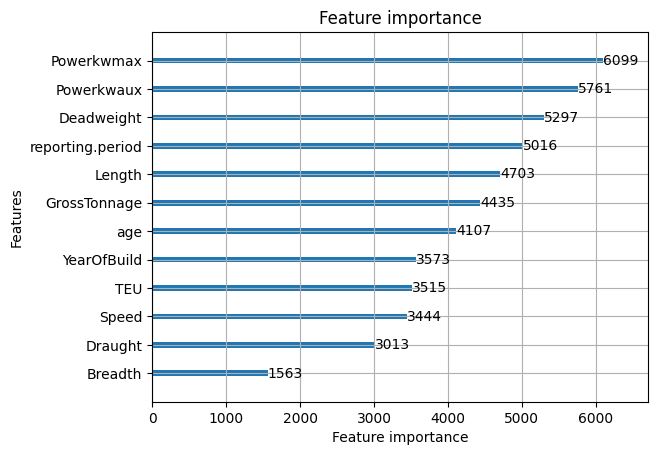

In [382]:
train_dataset.pop("Bulk carrier")
train_dataset.pop("Chemical tanker")
train_dataset.pop("Combination carrier")
train_dataset.pop("Container ship")
train_dataset.pop("Container/ro-ro cargo ship")
train_dataset.pop("Gas carrier")
train_dataset.pop("General cargo ship")
train_dataset.pop("Oil tanker")
train_dataset.pop("Other ship types")
train_dataset.pop("Passenger ship")
train_dataset.pop("Refrigerated cargo carrier")
train_dataset.pop("Ro-pax ship")
train_dataset.pop("Ro-ro ship")
train_dataset.pop("Vehicle carrier")
train_dataset.pop("Bulk Carriers")
train_dataset.pop("Dry Cargo/Passenger")
train_dataset.pop("Miscellaneous")
train_dataset.pop("Offshore")
train_dataset.pop("Tankers")
train_dataset.pop("LNG carrier")
test_dataset.pop("Bulk carrier")
test_dataset.pop("Chemical tanker")
test_dataset.pop("Combination carrier")
test_dataset.pop("Container ship")
test_dataset.pop("Container/ro-ro cargo ship")
test_dataset.pop("Gas carrier")
test_dataset.pop("General cargo ship")
test_dataset.pop("Oil tanker")
test_dataset.pop("Other ship types")
test_dataset.pop("Passenger ship")
test_dataset.pop("Refrigerated cargo carrier")
test_dataset.pop("Ro-pax ship")
test_dataset.pop("Ro-ro ship")
test_dataset.pop("Vehicle carrier")
test_dataset.pop("Bulk Carriers")
test_dataset.pop("Dry Cargo/Passenger")
test_dataset.pop("Miscellaneous")
test_dataset.pop("Offshore")
test_dataset.pop("Tankers")
test_dataset.pop("LNG carrier")

print("Running LGBM-TEU")

params = {      #with TEU on container ships excluding imputed TEU values
    'learning_rate'                    : 0.01,
    'num_leaves'                       : 127,
    'colsample_bytree'                 : 0.8124370484857427,
    'subsample'                        : 0.5403723632032212,
    'verbosity'                        : -1,
    'random_state'                     : 42,
    'device_type'                      : 'cpu',
    'objective'                        : 'regression',
    'metric'                           : 'l1',
    'num_threads'                      : 2,
    'reg_alpha'                        : 0.11111768592772804,
    'min_sum_hessian_in_leaf'          : 3.9921422643718656,
    'reg_lambda'                       : 0.00011673892277432164,
    'n_estimators'                     : 401
}

# Loading data
lgb_train = lgb.Dataset(train_dataset, train_labels)
lgb_eval = lgb.Dataset(test_dataset, test_labels, reference=lgb_train)
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=30)
lgb.plot_importance(model)
plt.show()

# For tuning hyperparameters
# tuner = LGBMTuner(metric='mae',trials=1000)
# tuner.fit(train_dataset, train_labels)
# tuner.plot_importances()
# tuner.plot_intermediate_values()
# tuner.plot_param_importances()
# tuner.plot_optimization_history()

test_predictions = model.predict(test_dataset)

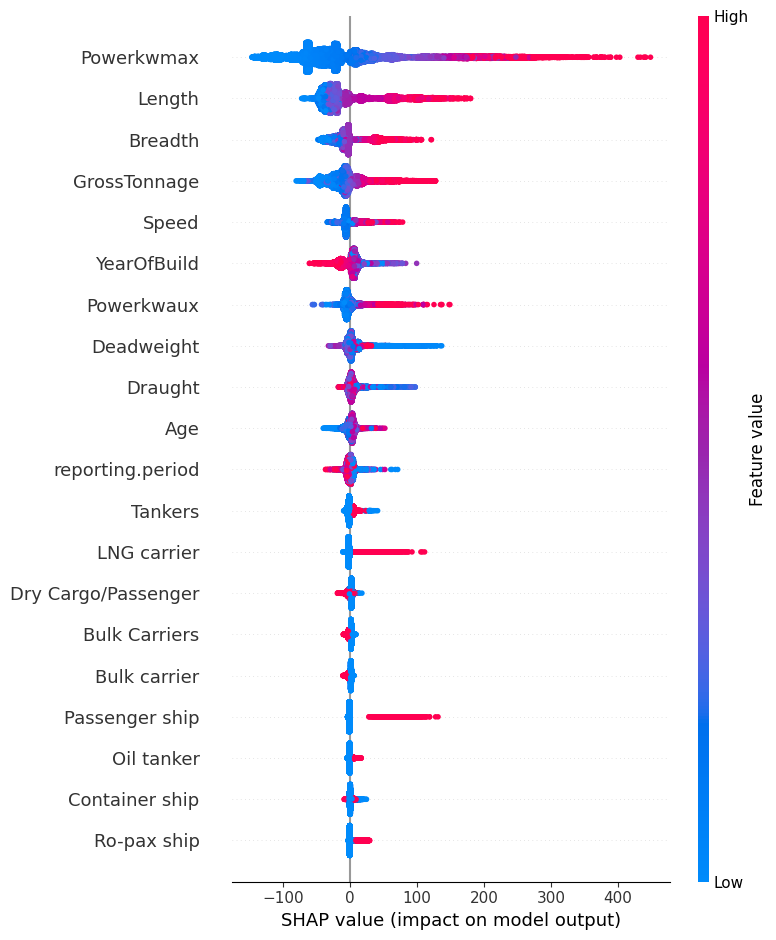

In [391]:
# Create Shap plot
# Shap plot displayed is for LGBM on all ship types

train_dataset.rename(columns = {'age':'Age'}, inplace = True)
shap_values = shap.TreeExplainer(model).shap_values(train_dataset)
shap.summary_plot(shap_values, train_dataset, show=False)

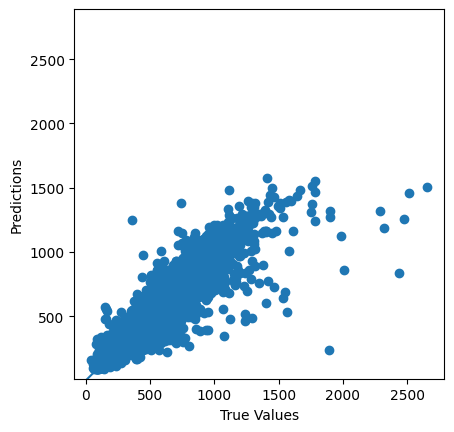

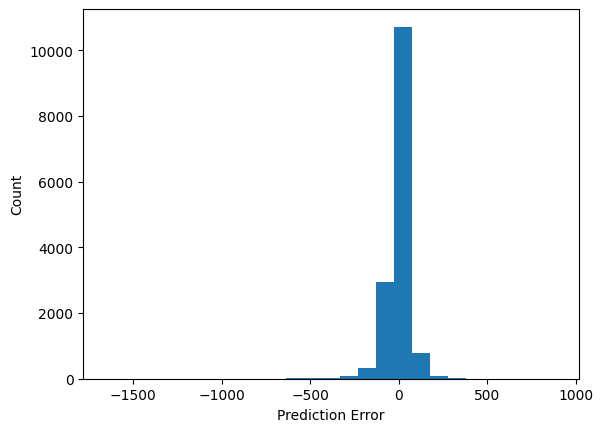

MAPE: 0.108961
NRMSE (range): 0.028335
NRMSE (sd): 0.327726
NRMSE (mean): 0.193331


In [393]:
# Plot actual vs predicted and output error metrics on test data

plt.scatter(test_labels,test_predictions)
plt.xlabel('True Values')
plt.ylabel("Predictions")
plt.axis('equal')
plt.axis('square')
_ = plt.plot([-100,100],[-100,100])
plt.show()

def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100


error = test_predictions - test_labels 
MAPE = mape(test_labels, test_predictions)
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")
plt.show()

print("MAPE: {:5.6f}".format(MAPE/100))

mse = mean_squared_error(test_labels, test_predictions)
rmse = math.sqrt(mse)
nrmse = rmse/(max(test_labels)-min(test_labels))
print("NRMSE (range): {:5.6f}".format(nrmse))
nrmse = rmse/(statistics.stdev(test_labels))
print("NRMSE (sd): {:5.6}".format(nrmse))
nrmse = rmse/(statistics.mean(test_labels))
print("NRMSE (mean): {:5.6f}".format(nrmse))

In [352]:
# Load in data for training on all of EU data, and predictions on IHS data

data1 = pd.read_csv("../data/nn-data-21.csv")
data2 = pd.read_csv("../data/test-data.csv")
full_train_data = data1.append(data2)
full_test_data = pd.read_csv("../data/IHS-imputed-rf.csv")

In [353]:
# Remove unwanted columns from IHS test data

full_test_data.loc[:,"reporting.period"] = 2023
full_test_data.loc[:,"age"] = 2023 - full_test_data["YearOfBuild"]
full_test_data.pop("ShipName")
full_test_data.pop("CallSign")
full_test_data.pop("MaritimeMobileServiceIdentityMMSINumber")
full_test_data.pop("FlagName")
full_test_data.pop("LengthOverallLOA")
full_test_data.pop("LengthRegistered")
full_test_TEU = full_test_data.pop("TEU")
full_test_data.pop("TEUCapacity14tHomogenous")
full_test_data.pop("BareboatCharterCompany")
full_test_data.pop("BareboatCharterCountryofControl")
full_test_data.pop("GroupBeneficialOwner")
full_test_data.pop("GroupBeneficialOwnerCountryOfControl")
full_test_data.pop("Operator")
full_test_data.pop("RegisteredOwner")
full_test_data.pop("RegisteredOwnerCountryofDomicile")
full_test_data.pop("RegisteredOwnerCountryOfRegistration")
full_test_data.pop("ExName")
full_test_data.pop("FlagEffectiveDate")
full_test_data.pop("ShiptypeLevel3")
full_test_data.pop("ShiptypeLevel4")
full_test_data.pop("Powerkwservice")
full_test_data.pop("Speedmax")
full_test_data.pop("Speedservice")
full_test_data.pop("TotalKilowattsofMainEngines")
full_test_data.pop("FlagNameBin")
full_test_data.pop("FlagNameContinent")
full_test_data.pop("ImputedValues")
full_test_data.pop("NumImputedValues")
full_test_data.pop("Deadweight_imputed")
full_test_data.pop("GrossTonnage_imputed")
full_test_data.pop("Length_imputed")
full_test_data.pop("Breadth_imputed")
full_test_data.pop("Draught_imputed")
full_test_data.pop("Powerkwmax_imputed")
full_test_data.pop("Powerkwaux_imputed")
full_test_data.pop("Speed_imputed")
full_test_data.pop("TEU_imputed")
full_test_data.pop("NumImputedFields")


shiptypeEU = pd.get_dummies(full_test_data["ShiptypeEU"])
full_test_data.pop("ShiptypeEU")
full_test_data = full_test_data.join(shiptypeEU)

shiptypelevel2 =pd.get_dummies(full_test_data["ShiptypeLevel2"])
full_test_data.pop("ShiptypeLevel2")
full_test_data = full_test_data.join(shiptypelevel2)

full_test_data = full_test_data[full_test_data["Fishing"] ==0]
full_test_data.pop("Fishing")

testIMO = full_test_data.pop("IMO.Number")

full_test_data = full_test_data.reindex(sorted(full_test_data.columns), axis=1)



In [354]:
# Remove unwanted variables from training data

shiptypeEU = pd.get_dummies(full_train_data["ShiptypeEU"])
full_train_data.pop("ShiptypeEU")
full_train_data = full_train_data.join(shiptypeEU)

shiptypelevel2 =pd.get_dummies(full_train_data["ShiptypeLevel2"])
full_train_data.pop("ShiptypeLevel2")
full_train_data = full_train_data.join(shiptypelevel2)

# operator =pd.get_dummies(dataset["Operator"])
full_train_data.pop("Operator")
# dataset = dataset.join(operator)

# FlagNameBin =pd.get_dummies(dataset["FlagNameBin"])
full_train_data.pop("FlagNameBin")
# dataset = dataset.join(FlagNameBin)

# FlagNameContinent =pd.get_dummies(dataset["FlagNameContinent"])
full_train_data.pop("FlagNameContinent")
# dataset = dataset.join(FlagNameContinent)


# Remove columns with boolean values
full_train_data.pop("Deadweight_imputed")
full_train_data.pop("GrossTonnage_imputed")
full_train_data.pop("Length_imputed")
full_train_data.pop("Breadth_imputed")
full_train_data.pop("Draught_imputed")
full_train_data.pop("Powerkwmax_imputed")
full_train_data.pop("Powerkwaux_imputed")
full_train_data.pop("Speed_imputed")
full_train_data.pop("TEU_imputed")

#remove 
full_train_data.pop("shiptype.original")
trainTEU = full_train_data.pop("TEU")
full_train_data.pop("NumImputedFields")

#remove EU params
full_train_data.pop("distance.traveled")
full_train_data.pop("average.speed")
full_train_data.pop("time.at.sea")

full_train_labels = full_train_data.pop("kg.CO2.per.nm")
full_train_data.pop("IMO")
full_train_data = full_train_data.reindex(sorted(full_train_data.columns), axis=1)


Running LGBM


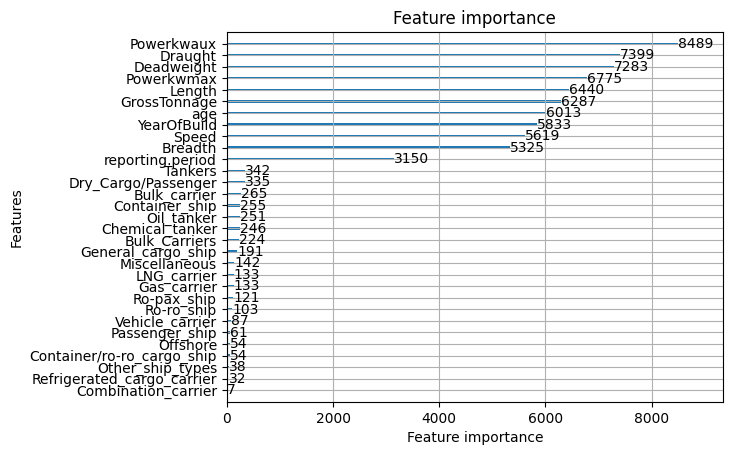

In [355]:
# Train LGBM on all EU data and make predictions on IHS data

print("Running LGBM")
params = {      # BEST PARAMS
'learning_rate'                    : 0.03,
'num_leaves'                       : 210,
'colsample_bytree'                 : 0.5075219704535351,
'subsample'                        : 0.5599262550238809,
'verbosity'                        : -1,
'random_state'                     : 42,
'device_type'                      : 'cpu',
'objective'                        : 'regression',
'metric'                           : 'l1',
'num_threads'                      : 2,
'reg_alpha'                        : 8.581024000021709e-08,
'min_sum_hessian_in_leaf'          : 0.2918528036972111,
'reg_lambda'                       : 2.4641613805417514e-06,
'n_estimators'                     : 343,
}

# Loading data
lgb_train = lgb.Dataset(full_train_data, full_train_labels)
model = lgb.train(params,
                 train_set=lgb_train,
                 )
lgb.plot_importance(model)
plt.show()

test_predictions = model.predict(full_test_data)

Running LGBM-TEU


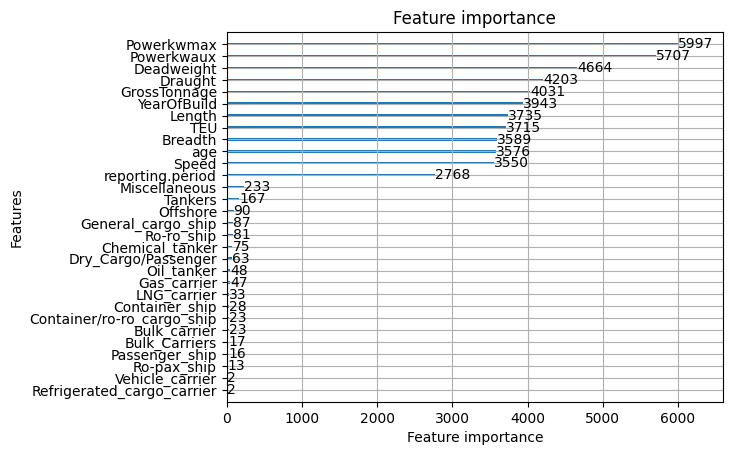

In [356]:
# Run predictions with TEU model

print("Running LGBM-TEU")

full_train_data.loc[:,"TEU"] = trainTEU
full_test_data.loc[:,"TEU"] = testTEU
params = {      #with TEU on container ships excluding imputed TEU values
    'learning_rate'                    : 0.01,
    'num_leaves'                       : 127,
    'colsample_bytree'                 : 0.8124370484857427,
    'subsample'                        : 0.5403723632032212,
    'verbosity'                        : -1,
    'random_state'                     : 42,
    'device_type'                      : 'cpu',
    'objective'                        : 'regression',
    'metric'                           : 'l1',
    'num_threads'                      : 2,
    'reg_alpha'                        : 0.11111768592772804,
    'min_sum_hessian_in_leaf'          : 3.9921422643718656,
    'reg_lambda'                       : 0.00011673892277432164,
    'n_estimators'                     : 401
}

# Loading data
lgb_train = lgb.Dataset(full_train_data, full_train_labels)
model = lgb.train(params,
                 train_set=lgb_train,
                 )
lgb.plot_importance(model)
plt.show()

test_predictions_TEU = model.predict(full_test_data)

In [357]:
# Set up output dataframe with predictions

datasetOut = pd.DataFrame({"IMO.Number": testIMO, "predicted.kg.CO2.per.nm": test_predictions, "TEU.predicted.kg.CO2.per.nm": test_predictions_TEU})
datasetOut.loc[full_test_data["Container ship"] == 0, "TEU.predicted.kg.CO2.per.nm"] = None

,IMO.Number,predicted.kg.CO2.per.nm,TEU.predicted.kg.CO2.per.nm
15,2186884,363.049481,NaN
16,2272334,372.439936,NaN
17,2274722,373.659247,NaN
18,2291081,114.843896,NaN
49,2611360,117.154093,NaN
...,...,...,...
128126,9918547,473.520703,NaN
128127,9918597,473.966637,NaN
128128,9918614,473.966637,NaN
128129,9918626,473.966637,NaN


In [348]:
# Save dataframe as csv. Find it under the data subdirectory

datasetOut.to_csv('database.csv')  